In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from pydub import AudioSegment
import numpy as np
import io
from scipy import stats

# plt use ggplot stylesheet
plt.style.use('ggplot')

In [2]:
# Load the JSON file
with open('temp/data_no_audio.json', 'r') as f:
    data = json.load(f)

len(data)

2932

## self-reported goals

In [3]:
aesthetic_goal = [entry for entry in data if entry.get('question') == 'aesthetics_focus']
referential_goal = [entry for entry in data if entry.get('question') == 'matching_focus']
print(f'Found {len(aesthetic_goal)} aesthetic goal trials and {len(referential_goal)} referential goal trials')

Found 257 aesthetic goal trials and 257 referential goal trials


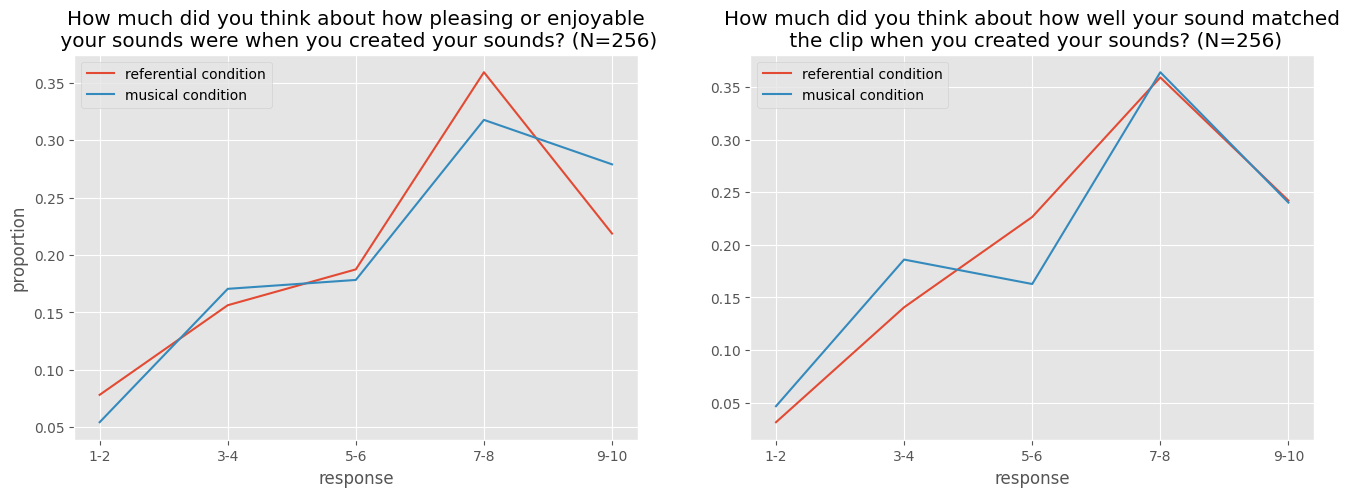

In [4]:
# aesthetic ratings by condition
aesthetic_ratings_ref = [entry.get('response') for entry in aesthetic_goal if entry.get('session_info', {}).get('condition') == 'referential']
aesthetic_ratings_mus = [entry.get('response') for entry in aesthetic_goal if entry.get('session_info', {}).get('condition') == 'musical']
ref_freqs_a = np.bincount(aesthetic_ratings_ref, minlength=11)[1:]
mus_freqs_a = np.bincount(aesthetic_ratings_mus, minlength=11)[1:]
ref_grouped_a = ref_freqs_a.reshape(-1, 2).sum(axis=1)
mus_grouped_a = mus_freqs_a.reshape(-1, 2).sum(axis=1)
ref_prop_a = ref_grouped_a / ref_grouped_a.sum()
mus_prop_a = mus_grouped_a / mus_grouped_a.sum()

# referential ratings by condition
referential_ratings_ref = [entry.get('response') for entry in referential_goal if entry.get('session_info', {}).get('condition') == 'referential']
referential_ratings_mus = [entry.get('response') for entry in referential_goal if entry.get('session_info', {}).get('condition') == 'musical']
ref_freqs_r = np.bincount(referential_ratings_ref, minlength=11)[1:]
mus_freqs_r = np.bincount(referential_ratings_mus, minlength=11)[1:]
ref_grouped_r = ref_freqs_r.reshape(-1, 2).sum(axis=1)
mus_grouped_r = mus_freqs_r.reshape(-1, 2).sum(axis=1)
ref_prop_r = ref_grouped_r / ref_grouped_r.sum()
mus_prop_r = mus_grouped_r / mus_grouped_r.sum()

# plot side-by-side
x_bins = np.arange(1, 6)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(x_bins, ref_prop_a, label='referential condition')
ax1.plot(x_bins, mus_prop_a, label='musical condition')
ax1.set_xticks(x_bins)
ax1.set_xticklabels(['1-2', '3-4', '5-6', '7-8', '9-10'])
ax1.set_xlabel('response')
ax1.set_ylabel('proportion')
ax1.set_title('How much did you think about how pleasing or enjoyable\n your sounds were when you created your sounds? (N=256)')
ax1.legend()
ax1.grid(True)

ax2.plot(x_bins, ref_prop_r, label='referential condition')
ax2.plot(x_bins, mus_prop_r, label='musical condition')
ax2.set_xticks(x_bins)
ax2.set_xticklabels(['1-2', '3-4', '5-6', '7-8', '9-10'])
ax2.set_xlabel('response')
# ax2.set_ylabel('proportion')
ax2.set_title('How much did you think about how well your sound matched\n the clip when you created your sounds? (N=256)')
ax2.legend()
ax2.grid(True)

# plt.tight_layout()
plt.subplots_adjust(hspace=2)
plt.show()


In [5]:
def _stats(arr):
    arr = np.array(arr)
    if arr.size:
        return arr.size, np.mean(arr), np.var(arr, ddof=1)
    return 0, np.nan, np.nan

def _print_section(title, goal_list):
    print(title)
    for cond in ('referential', 'musical'):
        arr = [e.get('response') for e in goal_list if e.get('session_info', {}).get('condition') == cond]
        n, m, v = _stats(arr)
        print(f"  {cond.ljust(10)} \tmean={m:6.2f}  var={v:6.2f}")
    print()

_print_section('How much did you think how well your sound matched the clip when you created your sounds?', aesthetic_goal)
_print_section('How much did you think about how pleasing or enjoyable your sounds were when you created your sounds?', referential_goal)

# print p-value
p_val = stats.ttest_ind(aesthetic_ratings_ref, aesthetic_ratings_mus, equal_var=False).pvalue
print(f'Aesthetic priority t-test p-value: \t{p_val:.4f}')
p_val = stats.ttest_ind(referential_ratings_ref, referential_ratings_mus, equal_var=False).pvalue
print(f'Referential priority t-test p-value: \t{p_val:.4f}')

How much did you think how well your sound matched the clip when you created your sounds?
  referential 	mean=  6.55  var=  5.89
  musical    	mean=  6.84  var=  6.09

How much did you think about how pleasing or enjoyable your sounds were when you created your sounds?
  referential 	mean=  6.80  var=  4.64
  musical    	mean=  6.71  var=  5.75

Aesthetic priority t-test p-value: 	0.3425
Referential priority t-test p-value: 	0.7687


## matching trials

In [6]:
matching_trials = [entry for entry in data if entry.get('study_phase') == 'matching_trial']
print(f'Found {len(matching_trials)} matching trials')

num_success = sum(1 for entry in matching_trials if entry.get('correct') == True)
print(f'Success rate: {num_success}/{len(matching_trials)} = {num_success / len(matching_trials) * 100:.2f}%')

Found 1028 matching trials
Success rate: 480/1028 = 46.69%


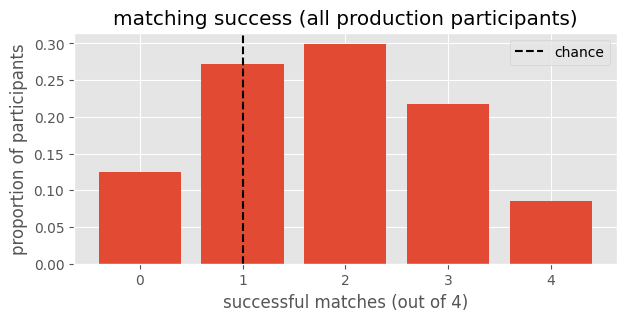

In [7]:
matching_trials_by_participant = {}

for entry in matching_trials:
    participant_id = entry.get('prolific').get('prolificSessionID')
    if participant_id not in matching_trials_by_participant:
        matching_trials_by_participant[participant_id] = []
    matching_trials_by_participant[participant_id].append(entry)

# Calculate success rates per participant, plot in histogram
success_rates = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
for participant_id, trials in matching_trials_by_participant.items():
    num_success = sum(1 for entry in trials if entry.get('correct') == True)
    success_rates[num_success] += 1


labels = list(success_rates.keys())
values = [success_rates[k]/sum(success_rates.values()) for k in labels]
plt.figure(figsize=(7, 3))
plt.bar(labels, values)
plt.axvline(x=1, color='k', linestyle='--', label='chance')
plt.xlabel('successful matches (out of 4)')
plt.ylabel('proportion of participants')
plt.title('matching success (all production participants)')
plt.xticks(labels)
plt.legend()
plt.show()

In [8]:
# Separate matching trials by condition
matching_trials_ref = [entry for entry in matching_trials if entry.get('session_info', {}).get('condition') == 'referential']
matching_trials_mus = [entry for entry in matching_trials if entry.get('session_info', {}).get('condition') == 'musical']

print(f'Referential trials: {len(matching_trials_ref)}')
print(f'Musical trials: {len(matching_trials_mus)}')

# Group by participant for each condition
matching_trials_by_participant_ref = {}
for entry in matching_trials_ref:
    participant_id = entry.get('prolific').get('prolificSessionID')
    if participant_id not in matching_trials_by_participant_ref:
        matching_trials_by_participant_ref[participant_id] = []
    matching_trials_by_participant_ref[participant_id].append(entry)

matching_trials_by_participant_mus = {}
for entry in matching_trials_mus:
    participant_id = entry.get('prolific').get('prolificSessionID')
    if participant_id not in matching_trials_by_participant_mus:
        matching_trials_by_participant_mus[participant_id] = []
    matching_trials_by_participant_mus[participant_id].append(entry)

# Calculate success rates for referential condition
success_rates_ref = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
for participant_id, trials in matching_trials_by_participant_ref.items():
    num_success = sum(1 for entry in trials if entry.get('correct') == True)
    success_rates_ref[num_success] += 1

# Calculate success rates for musical condition
success_rates_mus = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
for participant_id, trials in matching_trials_by_participant_mus.items():
    num_success = sum(1 for entry in trials if entry.get('correct') == True)
    success_rates_mus[num_success] += 1

ref = np.array([k for k, cnt in success_rates_ref.items() for _ in range(cnt)])
mus = np.array([k for k, cnt in success_rates_mus.items() for _ in range(cnt)])

# sample means and variances (sample variance ddof=1)
mean_ref = np.mean(ref)
var_ref = np.var(ref, ddof=1)
mean_mus = np.mean(mus)
var_mus = np.var(mus, ddof=1)

# two-sample t-test (Welch's t-test)
tstat, pval = stats.ttest_ind(ref, mus, equal_var=False)

print()
print(f"ref mean={mean_ref:.2f}, var={var_ref:.2f}")
print(f"mus mean={mean_mus:.2f}, var={var_mus:.2f}")
print(f"using 2-value t-test: p={pval:.4f}")

Referential trials: 512
Musical trials: 516

ref mean=2.02, var=1.31
mus mean=1.71, var=1.28
using 2-value t-test: p=0.0300


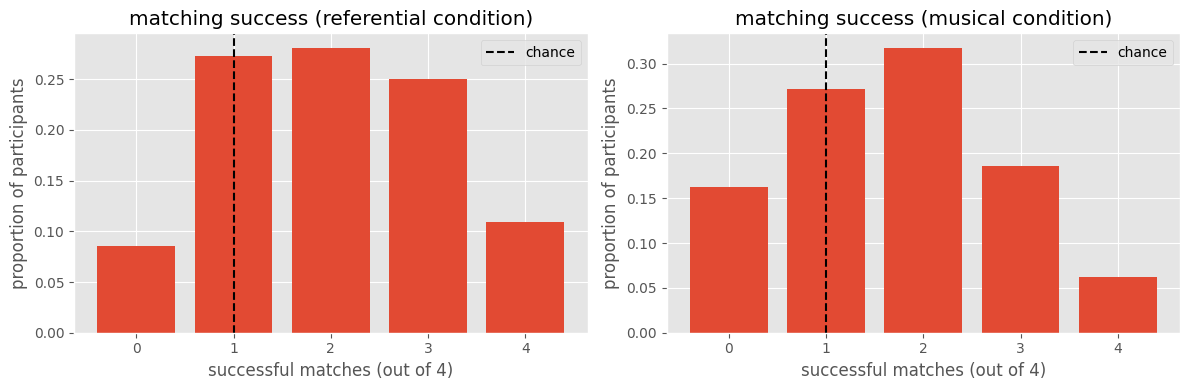

In [9]:
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Referential condition plot
labels = list(success_rates_ref.keys())
values_ref = [success_rates_ref[k]/sum(success_rates_ref.values()) for k in labels]
ax1.bar(labels, values_ref)
ax1.axvline(x=1, color='k', linestyle='--', label='chance')
ax1.set_xlabel('successful matches (out of 4)')
ax1.set_ylabel('proportion of participants')
ax1.set_title('matching success (referential condition)')
ax1.set_xticks(labels)
ax1.legend()

# Musical condition plot
values_mus = [success_rates_mus[k]/sum(success_rates_mus.values()) for k in labels]
ax2.bar(labels, values_mus)
ax2.axvline(x=1, color='k', linestyle='--', label='chance')
ax2.set_xlabel('successful matches (out of 4)')
ax2.set_ylabel('proportion of participants')
ax2.set_title('matching success (musical condition)')
ax2.set_xticks(labels)
ax2.legend()

plt.tight_layout()
plt.show()

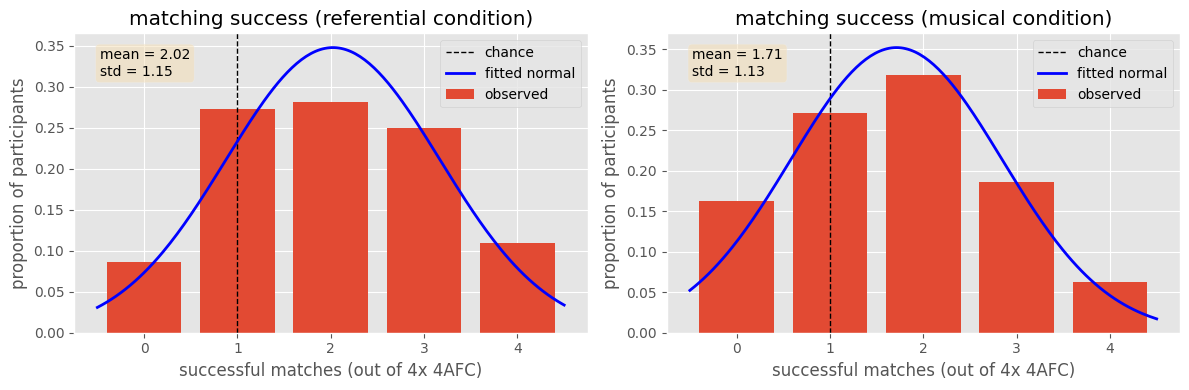

In [10]:
# Calculate standard deviations
std_ref = np.sqrt(var_ref)
std_mus = np.sqrt(var_mus)

# Create side-by-side plots with normal distributions overlaid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Referential condition plot
labels = list(success_rates_ref.keys())
values_ref = [success_rates_ref[k]/sum(success_rates_ref.values()) for k in labels]
ax1.bar(labels, values_ref, label='observed')
ax1.axvline(x=1, color='k', linestyle='--', label='chance', linewidth=1)

# Overlay normal distribution for referential
x_continuous = np.linspace(-0.5, 4.5, 200)
normal_ref = stats.norm.pdf(x_continuous, mean_ref, std_ref)
ax1.plot(x_continuous, normal_ref, 'b-', linewidth=2, label='fitted normal')
ax1.text(0.05, 0.95, f'mean = {mean_ref:.2f}\nstd = {std_ref:.2f}', 
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax1.set_xlabel('successful matches (out of 4x 4AFC)')
ax1.set_ylabel('proportion of participants')
ax1.set_title('matching success (referential condition)')
ax1.set_xticks(labels)
ax1.legend()

# Musical condition plot
values_mus = [success_rates_mus[k]/sum(success_rates_mus.values()) for k in labels]
ax2.bar(labels, values_mus, label='observed')
ax2.axvline(x=1, color='k', linestyle='--', label='chance', linewidth=1)

# Overlay normal distribution for musical
normal_mus = stats.norm.pdf(x_continuous, mean_mus, std_mus)
ax2.plot(x_continuous, normal_mus, 'b-', linewidth=2, label='fitted normal')
ax2.text(0.05, 0.95, f'mean = {mean_mus:.2f}\nstd = {std_mus:.2f}', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax2.set_xlabel('successful matches (out of 4x 4AFC)')
ax2.set_ylabel('proportion of participants')
ax2.set_title('matching success (musical condition)')
ax2.set_xticks(labels)
ax2.legend()

plt.tight_layout()
plt.show()


0.505859375 0.42829457364341084


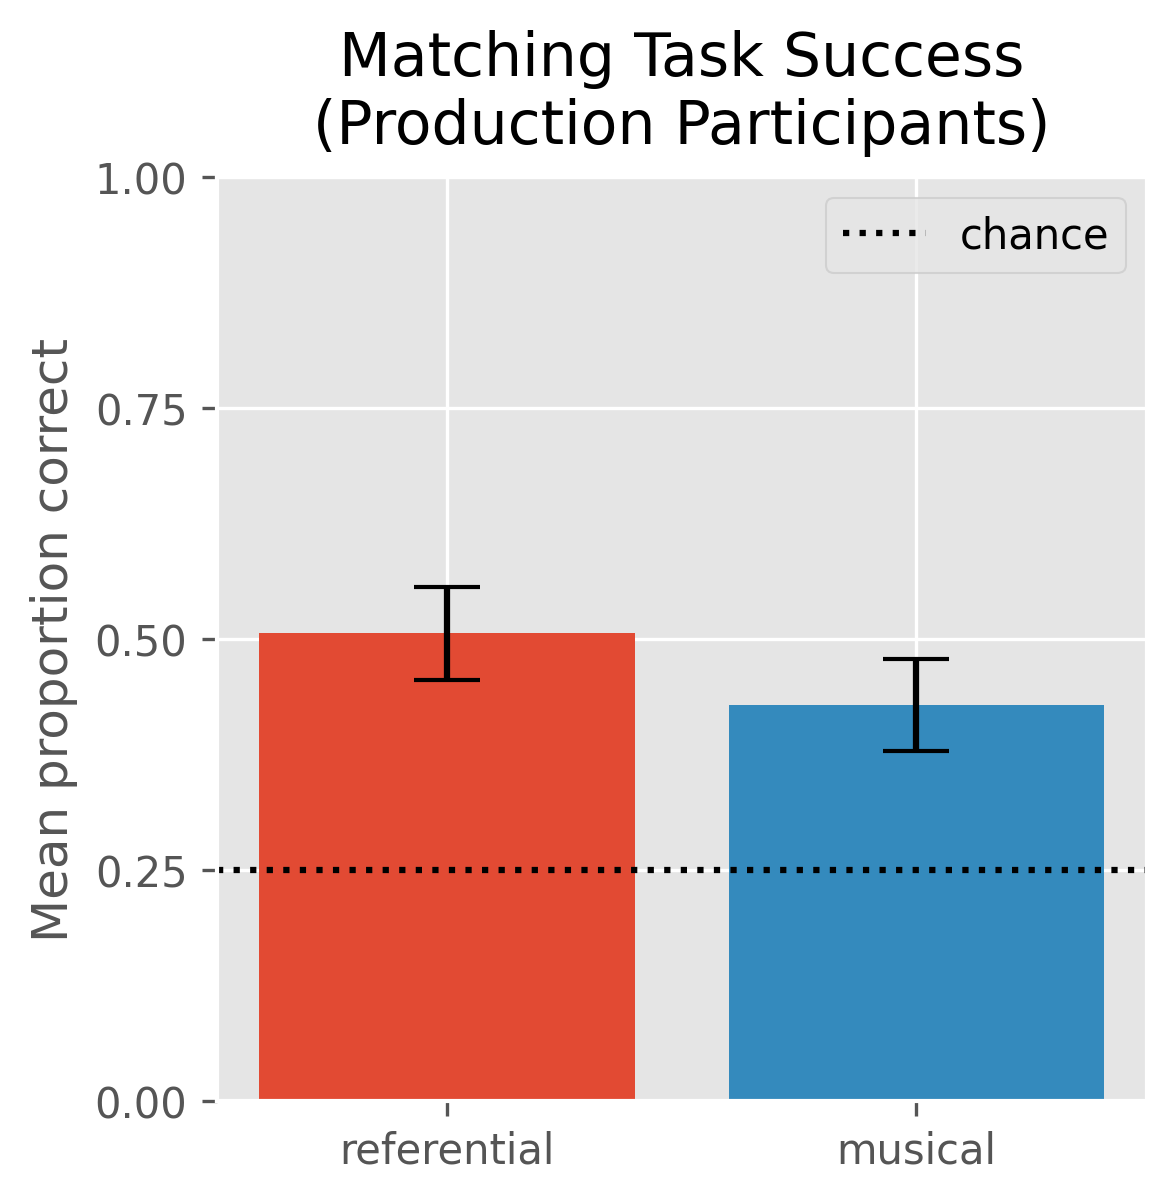

In [11]:
# ensure we have per-participant success counts for each condition
def _get_counts(var_name, rates_name, trials_by_participant_name):
    if var_name in globals():
        return np.array(globals()[var_name])
    if rates_name in globals():
        # expand dict {success_count: n_participants} -> list of success_count repeated n times
        return np.array([k for k, cnt in globals()[rates_name].items() for _ in range(cnt)])
    if trials_by_participant_name in globals():
        return np.array([sum(1 for e in trials if e.get('correct') == True)
                         for trials in globals()[trials_by_participant_name].values()])
    raise NameError(f"Cannot find {var_name}, {rates_name}, or {trials_by_participant_name}")

ref = _get_counts('success_counts_ref', 'success_rates_ref', 'matching_trials_by_participant_ref')
mus = _get_counts('success_counts_mus', 'success_rates_mus', 'matching_trials_by_participant_mus')

# bar plot: mean proportion correct per condition with 95% CI (t-based)
prop_ref = ref / 4.0
prop_mus = mus / 4.0

def mean_ci(x, alpha=0.05):
    n = len(x)
    m = np.mean(x)
    se = np.std(x, ddof=1) / np.sqrt(n)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    h = tcrit * se
    return m, h

m_ref, h_ref = mean_ci(prop_ref)
m_mus, h_mus = mean_ci(prop_mus)

conds = ['referential', 'musical']
means = [m_ref, m_mus]
errs = [h_ref, h_mus]

print(m_ref, m_mus)

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
x = np.arange(len(conds))
ax.bar(x, means, yerr=errs, capsize=8, color=['C0','C1'])
ax.set_xticks(x)
ax.set_xticklabels(conds)
ax.set_ylabel('Mean proportion correct')
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_title('Matching Task Success\n(Production Participants)', pad=8)

ax.axhline(y=0.25, color='k', linestyle=':', linewidth=1.5, label='chance')
ax.legend()

plt.show()

## comfort with instrument

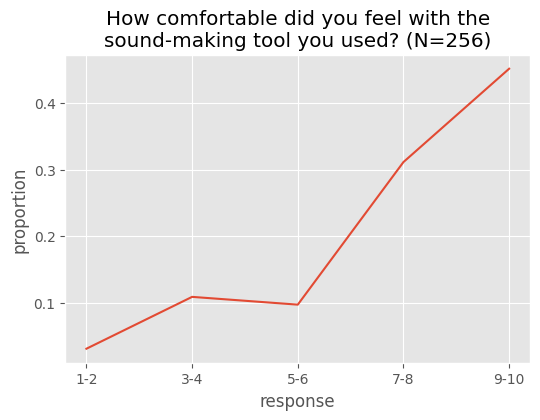

In [12]:
comfort_ratings = [entry.get('response') for entry in data if entry.get('question') == 'comfort']
comfort_freqs = np.bincount(comfort_ratings, minlength=11)[1:]
comfort_grouped = comfort_freqs.reshape(-1, 2).sum(axis=1)
comfort_prop = comfort_grouped / comfort_grouped.sum()

plt.figure(figsize=(6, 4))
x_bins = np.arange(1, 6)
plt.plot(x_bins, comfort_prop)
plt.xticks(x_bins, ['1-2', '3-4', '5-6', '7-8', '9-10'])
plt.xlabel('response')
plt.ylabel('proportion')
plt.title('How comfortable did you feel with the\nsound-making tool you used? (N=256)')
plt.grid(True)
plt.show()

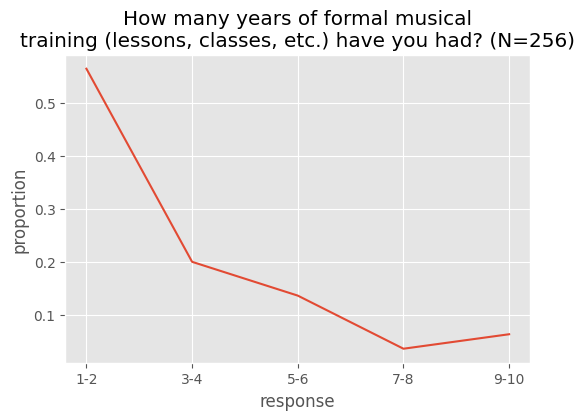

In [13]:
comfort_ratings = [entry.get('response') for entry in data if entry.get('question') == 'musical_experience']
comfort_freqs = np.bincount(comfort_ratings, minlength=11)[1:]
comfort_grouped = comfort_freqs.reshape(-1, 2).sum(axis=1)
comfort_prop = comfort_grouped / comfort_grouped.sum()

plt.figure(figsize=(6, 4))
x_bins = np.arange(1, 6)
plt.plot(x_bins, comfort_prop)
plt.xticks(x_bins, ['1-2', '3-4', '5-6', '7-8', '9-10'])
plt.xlabel('response')
plt.ylabel('proportion')
plt.title('How many years of formal musical\ntraining (lessons, classes, etc.) have you had? (N=256)')
plt.grid(True)
plt.show()

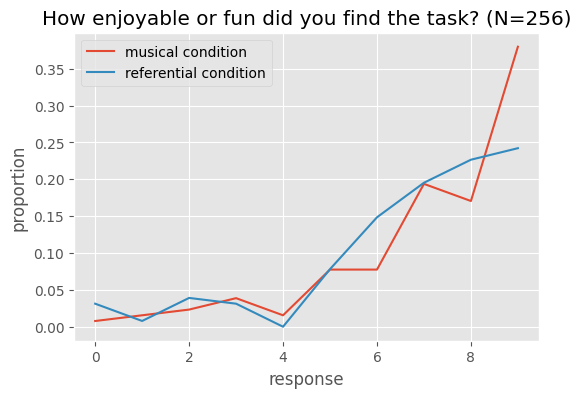

Average enjoyment (musical condition): 8.23
Average enjoyment (referential condition): 7.82
p-value: 0.1265


In [14]:
enjoyment_ratings_mus = [entry.get('response') for entry in data
                         if entry.get('question') == 'enjoyment' and entry.get('session_info', {}).get('condition') == 'musical']
enoyment_mus_freqs = np.bincount(enjoyment_ratings_mus, minlength=11)[1:]
# enjoyment_mus_grouped = enoyment_mus_freqs.reshape(-1, 2).sum(axis=1)
enjoyment_mus_prop = enoyment_mus_freqs / enoyment_mus_freqs.sum()

enjoyment_ratings_ref = [entry.get('response') for entry in data
                         if entry.get('question') == 'enjoyment' and entry.get('session_info', {}).get('condition') == 'referential']
enjoyment_ref_freqs = np.bincount(enjoyment_ratings_ref, minlength=11)[1:]
# enjoyment_ref_grouped = enjoyment_ref_freqs.reshape(-1, 2).sum(axis=1)
enjoyment_ref_prop = enjoyment_ref_freqs / enjoyment_ref_freqs.sum()


plt.figure(figsize=(6, 4))
plt.plot(enjoyment_mus_prop, label='musical condition')
plt.plot(enjoyment_ref_prop, label='referential condition')
# plt.xticks(x_bins, ['1-2', '3-4', '5-6', '7-8', '9-10'])
plt.xlabel('response')
plt.ylabel('proportion')
plt.title('How enjoyable or fun did you find the task? (N=256)')
plt.grid(True)
plt.legend()
plt.show()

print(f'Average enjoyment (musical condition): {np.mean(enjoyment_ratings_mus):.2f}')
print(f'Average enjoyment (referential condition): {np.mean(enjoyment_ratings_ref):.2f}')
print(f'p-value: {stats.ttest_ind(enjoyment_ratings_mus, enjoyment_ratings_ref, equal_var=False).pvalue:.4f}')